# **Portfolio Optimization using `yfinance`**


This notebook demonstrates how to:
1. **Collect stock market data** using `yfinance`.
2. **Calculate expected returns and covariance matrix** for a 1-month-ahead projection.
3. **Optimize portfolio weights** to minimize risk.
4. **Analyze the annual performance** of the optimized portfolio.

We’ll walk through the entire process step-by-step, providing code explanations and output interpretation.


## **Step 1: Import Required Libraries**

In [1]:

# Install yfinance if not installed
# !pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize



### **Explanation:**
- **`yfinance`**: Download historical stock data.
- **`numpy`**: Perform numerical operations (e.g., matrix multiplication).
- **`pandas`**: Handle and manipulate data in DataFrames.
- **`matplotlib`**: Plot visualizations.
- **`scipy.optimize`**: Optimize portfolio weights by minimizing risk.


## **Step 2: Collect Data using `yfinance`**

In [2]:

# Define the stock tickers for the portfolio
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

# Download 1 year of daily adjusted close prices
data = yf.download(tickers, start="2023-01-01", end="2024-01-01")['Adj Close']

# Calculate daily returns and convert them to monthly returns
returns = data.pct_change().dropna()
monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)

# Calculate expected returns and covariance matrix
expected_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()

print("Expected Returns:\n", expected_returns)
print("Covariance Matrix:\n", cov_matrix)


[*********************100%***********************]  5 of 5 completed

Expected Returns:
 Ticker
AAPL     0.039283
AMZN     0.051724
GOOGL    0.040983
MSFT     0.040573
TSLA     0.092039
dtype: float64
Covariance Matrix:
 Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
Ticker                                                  
AAPL    0.004958  0.004398  0.002818  0.002841  0.010368
AMZN    0.004398  0.006741  0.004662  0.002490  0.010482
GOOGL   0.002818  0.004662  0.006341  0.001995  0.004859
MSFT    0.002841  0.002490  0.001995  0.003524  0.000386
TSLA    0.010368  0.010482  0.004859  0.000386  0.050845



/var/folders/36/pdgz39t93t13mnrp84bqbcsm0000gn/T/ipykernel_53812/3907669574.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)



### **Explanation:**
- **`tickers`**: List of stock tickers (Apple, Microsoft, Google, Amazon, Tesla).
- **`yf.download()`**: Downloads daily adjusted close prices for the selected tickers.
- **`pct_change()`**: Converts prices to daily returns.
- **`resample('M')`**: Aggregates daily returns to monthly returns.
- **`mean()`**: Computes the average (expected) return for each stock.
- **`cov()`**: Computes the covariance matrix of the returns.

### **Output Interpretation:**
- **Expected Returns**: Displays the average monthly return for each stock.
- **Covariance Matrix**: Shows how the returns of the stocks move together (essential for risk estimation).


## **Step 3: Define Portfolio Optimization Functions**

In [3]:

# Objective function: Minimize portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Constraint: Sum of weights must equal 1
def constraint(weights):
    return np.sum(weights) - 1

# Bounds: No short-selling, weights between 0 and 1
bounds = [(0, 1) for _ in range(len(tickers))]

# Initial guess: Equal allocation
initial_guess = np.array([1 / len(tickers)] * len(tickers))



### **Explanation:**
- **`portfolio_variance()`**: Calculates the portfolio's variance (risk) using matrix multiplication.
- **`constraint()`**: Ensures the sum of the portfolio weights is 1 (fully invested).
- **`bounds`**: Constrains weights between 0 and 1 (no short-selling).
- **`initial_guess`**: Starts with equal allocation across all stocks.

### **Matrix Multiplication Insight:**
- **Variance formula:** \( \sigma^2_p = W^T \cdot \Sigma \cdot W \)
  - \( W \) = Portfolio weights
  - \( \Sigma \) = Covariance matrix
  This is why matrix multiplication is crucial for portfolio optimization.


## **Step 4: Perform Portfolio Optimization**

In [4]:

# Minimize portfolio variance subject to constraints
opt_result = minimize(
    portfolio_variance,
    initial_guess,
    args=(cov_matrix,),
    method='SLSQP',
    constraints={'type': 'eq', 'fun': constraint},
    bounds=bounds
)

# Extract optimal portfolio weights
optimal_weights = opt_result.x
print("Optimal Portfolio Weights:\n", optimal_weights)


Optimal Portfolio Weights:
 [2.26828696e-01 6.93889390e-18 2.02710123e-01 5.70461180e-01
 0.00000000e+00]



### **Explanation:**
- **`minimize()`**: Optimizes portfolio weights by minimizing the variance.
- **`SLSQP`**: Sequential Least Squares Programming (constrained optimization method).
- **`opt_result.x`**: Stores the optimal weights for each stock.

### **Output Interpretation:**
- The optimal weights will indicate how much of the portfolio should be allocated to each stock to minimize risk.


## **Step 5: Visualize Portfolio Allocation**

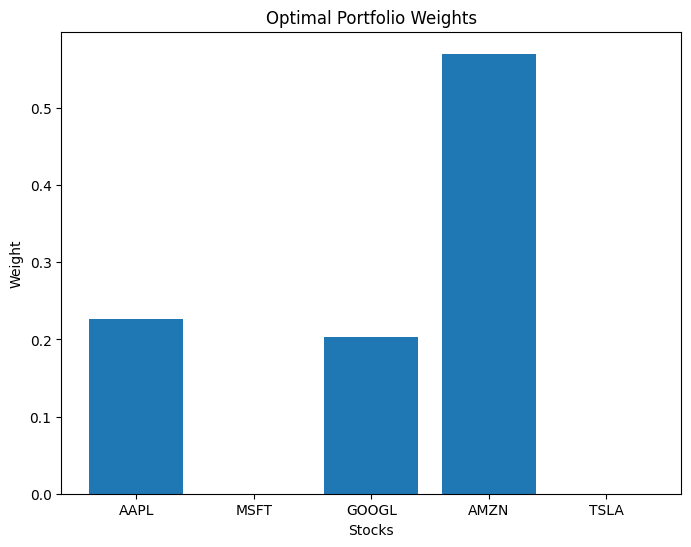

In [5]:

# Plot optimal weights
plt.figure(figsize=(8, 6))
plt.bar(tickers, optimal_weights)
plt.title('Optimal Portfolio Weights')
plt.xlabel('Stocks')
plt.ylabel('Weight')
plt.show()



### **Output Interpretation:**
- This bar chart shows the optimal weights for each stock in the portfolio.
- The higher the weight, the more that stock contributes to the overall portfolio.


## **Step 6: Annual Performance Analysis**

In [6]:

# Calculate monthly portfolio returns using optimal weights
portfolio_returns = monthly_returns.dot(optimal_weights)

# Calculate annual return and volatility
annual_return = (1 + portfolio_returns).prod() - 1
annual_volatility = portfolio_returns.std() * np.sqrt(12)

print(f"Annual Return: {annual_return:.2%}")
print(f"Annual Volatility: {annual_volatility:.2%}")


Annual Return: 58.27%
Annual Volatility: 19.34%



### **Explanation:**
- **Annual Return**: The cumulative product of monthly returns over the year.
- **Annual Volatility**: Standard deviation of monthly returns, scaled by \( \sqrt{12} \) to reflect annual volatility.

### **Output Interpretation:**
- **Annual Return**: Displays the portfolio's return over the year.
- **Annual Volatility**: Shows the portfolio’s risk over the year.


## **Step 7: Visualize Annual Performance**

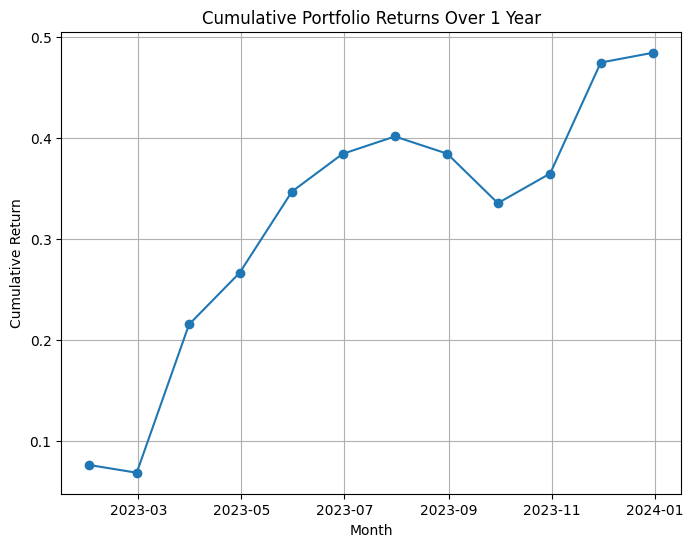

In [7]:

# Plot cumulative returns over the year
plt.figure(figsize=(8, 6))
plt.plot(portfolio_returns.cumsum(), marker='o')
plt.title('Cumulative Portfolio Returns Over 1 Year')
plt.xlabel('Month')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()



### **Output Interpretation:**
- This plot shows how the portfolio's cumulative return evolved over the year.
- It provides a visual understanding of the portfolio’s growth and fluctuations.
